## 1. Introduction

In [735]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder
sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load Data

In [648]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [649]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list ( k for k , v in outlier_indices.items() if v > n)
    
    return multiple_outliers

In [650]:
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [651]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [652]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

### 2.3 Joining train and test set

In [653]:
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

### 2.4 Check for null and missing values

In [654]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [655]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [656]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Feature Analysis

### 3.1 Numerical Values

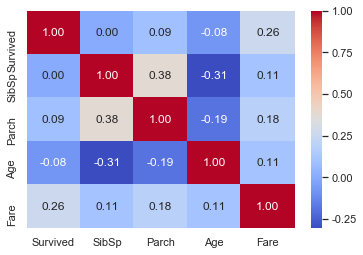

In [657]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

Fare만 Survived와 유의한 상관 관계가 있는 것으로 보입니다.

다른 기능이 유용하지 않다는 의미는 아닙니다. 
특징중의 일부 소집단은 생존과 상관 될 수 있습니다. 
이를 확인하려면 이러한 기능을 자세히 살펴 봐야합니다.

#### SibSp

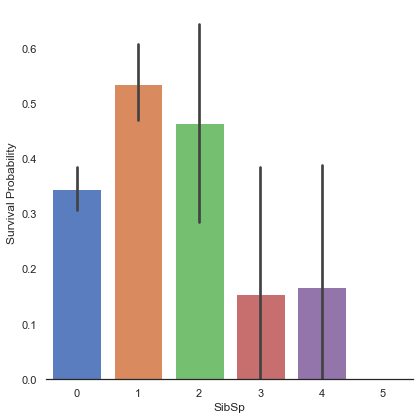

In [658]:
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

형제 자매 / 배우자가 많은 승객은 생존 할 기회가 적은 것 같습니다

단일 승객 (0 SibSP) 또는 다른 두 사람 (SibSP 1 또는 2)과 함께 생존 할 가능성이 더 높습니다

이 관찰은 매우 흥미 롭습니다. 이러한 범주를 설명하는 새로운 기능을 고려할 수 있습니다

#### Parch

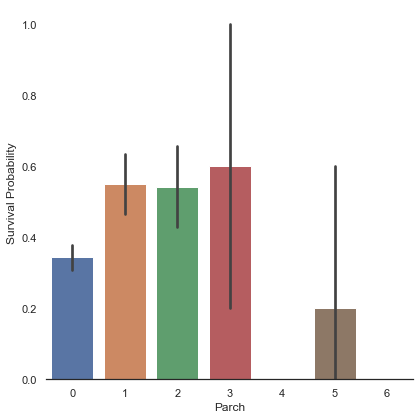

In [659]:
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6)
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

소가족은 독신 (Parch 0), 중형 (Parch 3,4) 및 대가족 (Parch 5,6)보다 생존 가능성이 높습니다.

부모 / 자녀가 3 명인 승객의 생존에 중요한 표준 편차가 있음에주의하십시오.

#### Age

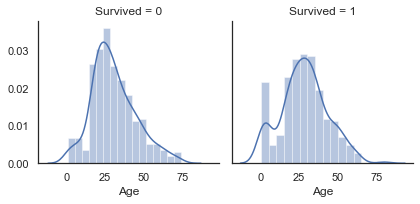

In [660]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

연령 분포는 꼬리 분포, 가우스 분포 일 수 있습니다.

우리는 연령 분포가 살아남은 하위 집단에서 동일하지 않다는 것을 알 수 있습니다. 실제로, 살아남은 젊은 승객에 해당하는 최고점이 있습니다. 우리는 또한 60-80 세의 승객이 덜 생존 한 것으로 나타났습니다.

따라서 "나이"가 "생존"과 상관되지 않더라도 생존 할 확률이 어느 정도 인 승객의 연령 범주가 있음을 알 수 있습니다.

아주 어린 승객은 생존 할 확률이 더 높습니다.

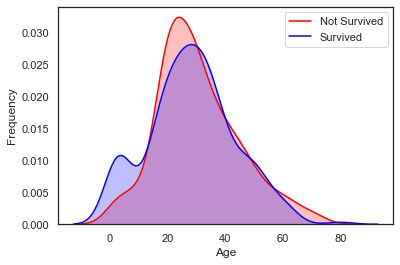

In [661]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True, label='Not Survived')
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], color='Blue', shade=True, label='Survived')
g.set_xlabel('Age')
g = g.set_ylabel('Frequency')

5세 미만의 유아에서 가장 큰 갭을 발견할수 있다.

#### Fare

In [662]:
dataset['Fare'].isnull().sum()

1

In [663]:
dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)

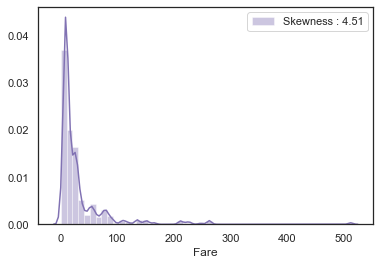

In [664]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

운임 분포는 매우 왜곡되어 있습니다. 이것은 스케일링 되어도 모델에서 매우 높은 값을 과도하게 만들 수 있습니다.

이 경우이 비뚤어 짐을 줄이기 위해 로그 기능으로 변환하는 것이 좋습니다.

In [665]:
dataset['Fare'] = np.log1p(dataset['Fare'])

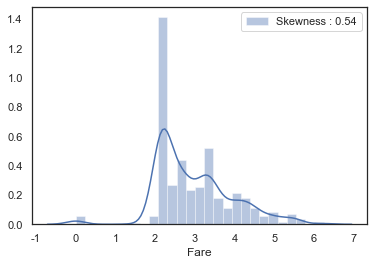

In [666]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

### 3.2 Categorical Values

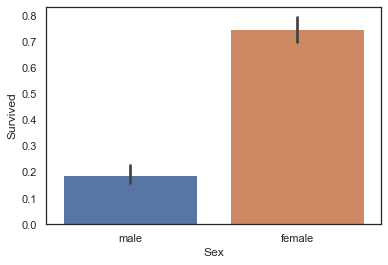

In [667]:
g = sns.barplot(x='Sex', y='Survived', data=train)

In [668]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


 "Women and children first".

#### Pclass

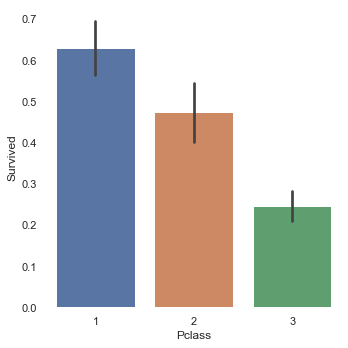

In [669]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar')
g = g.despine(left=True, bottom=True)

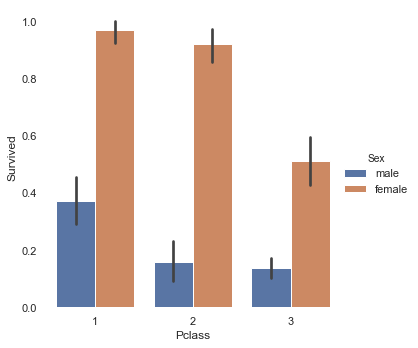

In [670]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, kind='bar')
g = g.despine(left=True, bottom=True)

We live in the unfair world, money is important to live

#### Embarked

In [671]:
dataset['Embarked'].isnull().sum()

2

In [672]:
dataset.groupby(['Embarked']).count()

,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
Embarked,,,,,,,,,,,
C,212,118,270,270,270,270,270,270,270,168,270
Q,50,5,123,123,123,123,123,123,123,77,123
S,779,167,904,904,904,904,904,904,904,634,904


In [673]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

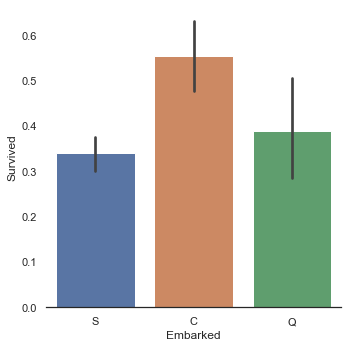

In [674]:
g = sns.factorplot(x='Embarked', y='Survived', data=train, kind='bar')
g = g.despine(left='True')

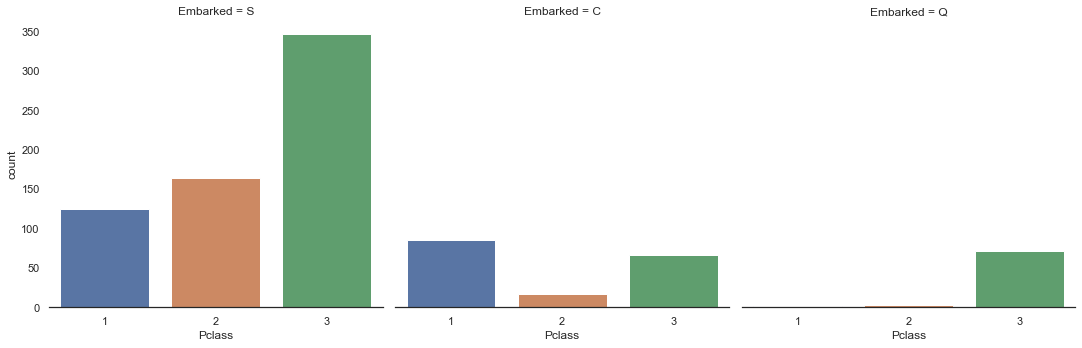

In [675]:
g = sns.factorplot('Pclass', col='Embarked', data=train, kind='count')
g = g.despine(left='True')

## 4. Filling Missing Values

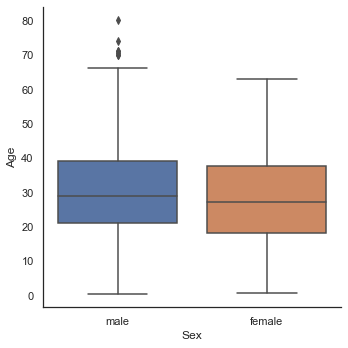

In [676]:
g = sns.factorplot(y='Age', x='Sex', data=train, kind='box')

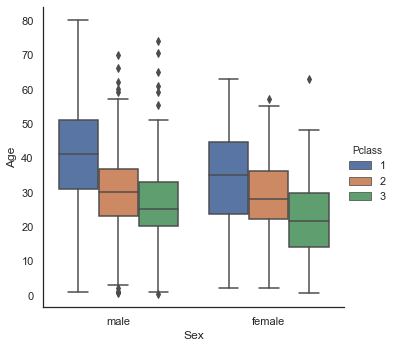

In [677]:
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=train, kind='box')

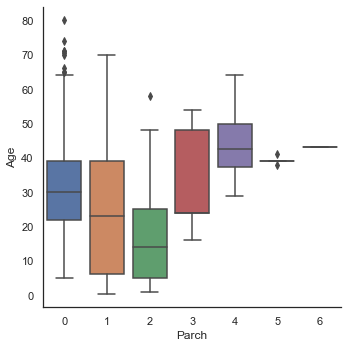

In [678]:
g = sns.factorplot(y='Age', x='Parch', data=train, kind='box')

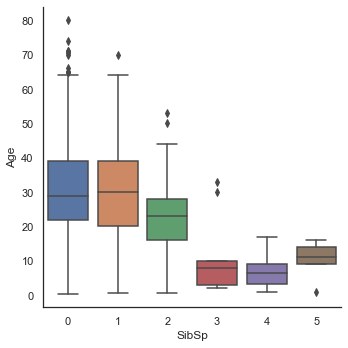

In [679]:
g = sns.factorplot(y='Age', x='SibSp', data=train, kind='box')

In [680]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

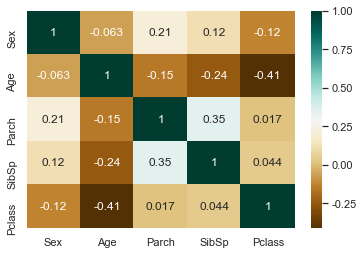

In [681]:
g = sns.heatmap(dataset[['Sex','Age','Parch','SibSp', 'Pclass']].corr(), annot=True, cmap='BrBG')

In [682]:
def fill_age(Pclass, SibSp, Parch):
    return dataset[
        (dataset.Pclass == Pclass) & (dataset.SibSp == SibSp) & (dataset.Parch == Parch)].median()['Age']

In [683]:
age = dataset[dataset['Age'].isna()].apply(lambda x : fill_age(x.Pclass, x.SibSp, x.Parch), axis=1 )

In [684]:
dataset.loc[dataset['Age'].isna(),'Age'] = age

In [685]:
dataset.loc[dataset['Age'].isna(),'Age'] = dataset['Age'].median()

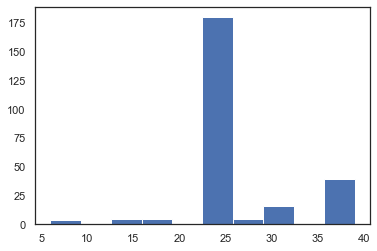

In [686]:
plt.hist(age)
plt.show()

## 5. Feature Engineering

### 5.1 Name/Title

In [687]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [688]:
title = []
for name in dataset['Name']:
    title.append(name.split(',')[1].split('.')[0].strip())
dataset['Title'] = title

In [689]:
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

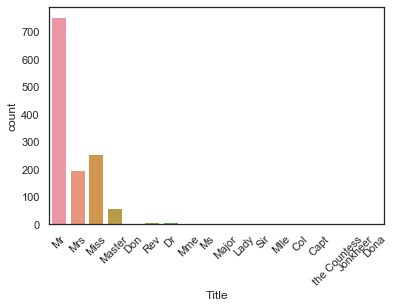

In [690]:
g = sns.countplot(x='Title', data=dataset)
g = plt.xticks(rotation=45)

In [691]:
dataset["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [692]:
def convert_title(x):
    if x in ['Lady', 'Dona','Ms','Mlle']:
        return 'Miss'
    elif x in ['Mme']:
        return 'Mrs'
    elif x in ['the Countess','Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer','Master']:
        return 'Mr'
    else:
        return x

In [693]:
dataset['Title'] = dataset.Title.map(lambda x : convert_title(x))

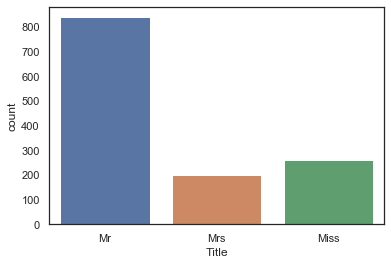

In [694]:
g = sns.countplot(dataset["Title"])

### 5.2 Family Size

In [695]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

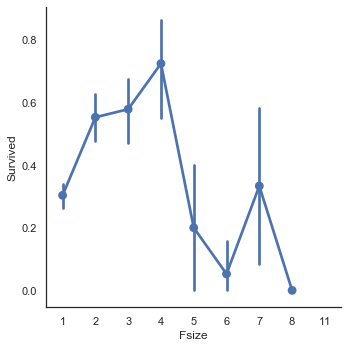

In [696]:
g = sns.factorplot(x='Fsize', y='Survived', data=dataset)

In [697]:
dataset['Single'] = dataset['Fsize'].map(lambda x : 1 if x == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda x : 1 if x == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda x : 1 if 3<=x<=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda x : 1 if x > 5 else 0)

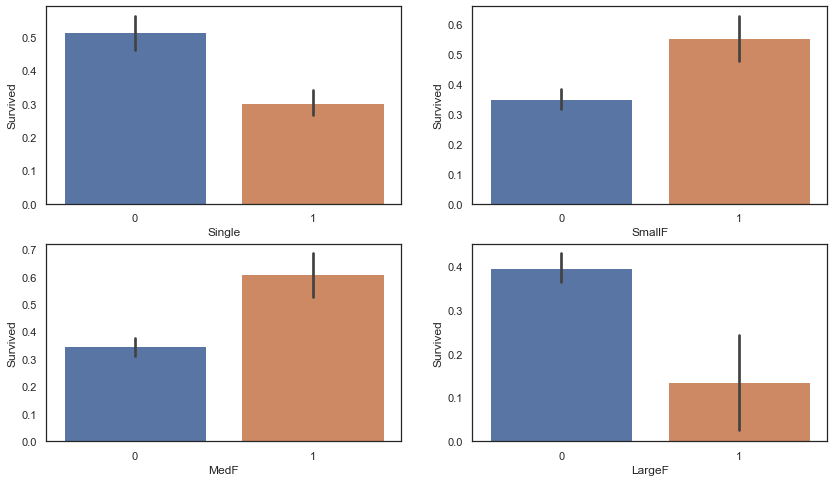

In [698]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 8))

g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar' ,ax=ax1)
plt.close(g.fig)
g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar',ax=ax2)
plt.close(g.fig)
g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar',ax=ax3)
plt.close(g.fig)
g = sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar',ax=ax4)
plt.close(g.fig)

In [699]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [700]:
dataset.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Single,SmallF,MedF,LargeF,Title_Miss,Title_Mr,Title_Mrs,Em_C,Em_Q,Em_S
0,22.0,NaN,2.110213,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,...,0,1,0,0,0,1,0,0,0,1
1,38.0,C85,4.280593,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,...,0,1,0,0,0,0,1,1,0,0
2,26.0,NaN,2.188856,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,...,1,0,0,0,1,0,0,0,0,1
3,35.0,C123,3.990834,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,...,0,1,0,0,0,0,1,0,0,1
4,35.0,NaN,2.202765,"Allen, Mr. William Henry",0,5,3,0,0,0.0,...,1,0,0,0,0,1,0,0,0,1


In [701]:
dataset.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'B78', 'D33',
       'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12',
       'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47', 'B86', 'F2',
       'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4', 'B80', 'A31',
       'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77', 'E67', 'B94',
       'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D', 'C22 C26', 'C106',
       'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18',
       'C124', 'C91', 'E40', 'T', 'C128', 'D37', 'B35', 'E50', 'C82',
       'B96 B98', 'E10', 'E44', 'C23 C25 C27', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

### 5.3 Fare

In [702]:
dataset['Fare_Range'] = pd.qcut(dataset['Fare'],4)
dataset.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='Oranges')

,Survived
Fare_Range,
"(-0.001, 2.186]",0.197309
"(2.186, 2.738]",0.303571
"(2.738, 3.453]",0.456221
"(3.453, 6.241]",0.59447


In [703]:
dataset['Fare_cat'] = 0
dataset.loc[dataset['Fare'] <= 2.186, 'Fare_cat'] = 0
dataset.loc[ (dataset['Fare'] > 2.186) & (dataset['Fare'] <= 2.738), 'Fare_cat'] = 1
dataset.loc[ (dataset['Fare'] > 2.738) & (dataset['Fare'] <= 3.453), 'Fare_cat'] = 2
dataset.loc[dataset['Fare'] > 3.453, 'Fare_cat'] = 3

In [704]:
dataset['Fare_cat'].unique()

array([0, 3, 1, 2], dtype=int64)

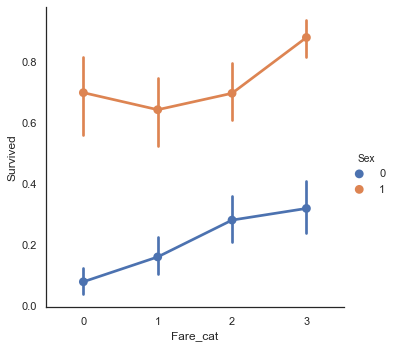

In [705]:
sns.factorplot('Fare_cat', 'Survived', data=dataset, hue='Sex',)
plt.show()

In [706]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

In [707]:
ds = dataset[dataset.Cabin != 'X']
le = LabelEncoder()
ds['Cabin'] = le.fit_transform(ds['Cabin'])

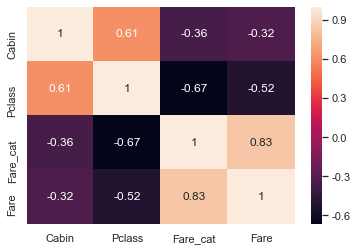

In [708]:
g = sns.heatmap(ds[['Cabin','Pclass','Fare_cat', 'Fare']].corr(), annot=True)

In [709]:
from collections import Counter 
  
def most_frequent(List): 
    #print(List)
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

In [710]:
def find_cabin(pclass, fare, cabin):
    if cabin != 'X':
        return cabin
    ds = dataset[(dataset.Pclass==pclass) & (dataset.Cabin != 'X') & (dataset.Fare_cat == fare)]['Cabin'].values
    if len(ds) == 0:
        return 'X'
    return most_frequent ( ds )

In [711]:
dataset.Cabin = dataset.apply(lambda x : find_cabin(x.Pclass, x.Fare_cat, x.Cabin), axis=1)

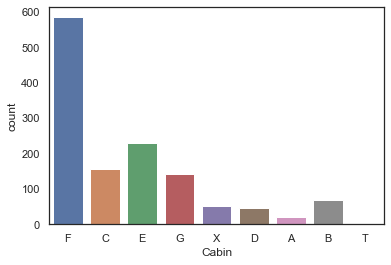

In [712]:
sns.countplot(dataset['Cabin'])

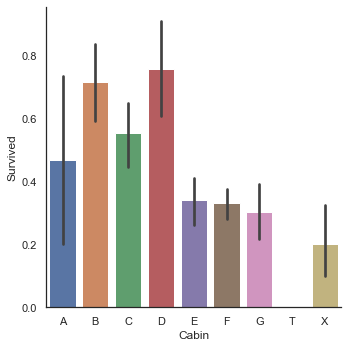

In [713]:
g = sns.factorplot(x='Cabin', y='Survived', data=dataset, kind='bar', order=['A','B','C','D','E','F','G','T','X'])

In [714]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

### 5.4 Ticket

In [715]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [716]:
dataset.drop(columns=['Ticket','Name','Fare_Range','PassengerId'], inplace=True)

In [717]:
dataset.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Survived,Fsize,Single,SmallF,...,Fare_cat,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,2.110213,0,3,0,1,0.0,2,0,1,...,0,0,0,0,0,0,1,0,0,0
1,38.0,4.280593,0,1,1,1,1.0,2,0,1,...,3,0,0,1,0,0,0,0,0,0
2,26.0,2.188856,0,3,1,0,1.0,1,1,0,...,1,0,0,0,0,1,0,0,0,0
3,35.0,3.990834,0,1,1,1,1.0,2,0,1,...,3,0,0,1,0,0,0,0,0,0
4,35.0,2.202765,0,3,0,0,0.0,1,1,0,...,1,0,0,0,0,1,0,0,0,0


## 6. Modeling

In [718]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(columns=['Survived'], inplace=True)

In [719]:
train['Survived'] = train['Survived'].astype('int')
y_train = train['Survived']
X_train = train.drop(columns=['Survived'])

In [720]:
X_train.columns

Index(['Age', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Fsize', 'Single',
       'SmallF', 'MedF', 'LargeF', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Em_C', 'Em_Q', 'Em_S', 'Fare_cat', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X'],
      dtype='object')

### 6.1 Baseline Model

#### 6.1.1 Cross validate models
Compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [721]:
kfold = StratifiedKFold(n_splits=10)

In [722]:
random_state=2
classifiers = [
    SVC(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                      random_state=random_state, learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state),
    LinearDiscriminantAnalysis()
]

In [723]:
cv_means = []
cv_std = []
for classifier in classifiers:
    results = cross_val_score(classifier, X_train, y_train, scoring='accuracy',
                                     cv=kfold, n_jobs=1)
    cv_means.append(results.mean())
    cv_std.append(results.std())

cv_res = pd.DataFrame(
    {
        'Algorithm':[type(model).__name__ for model in classifiers],
        'Mean':cv_means,
        'Error':cv_std,
    }
)

Text(0.5, 1.0, 'Cross Validation Accuracy')

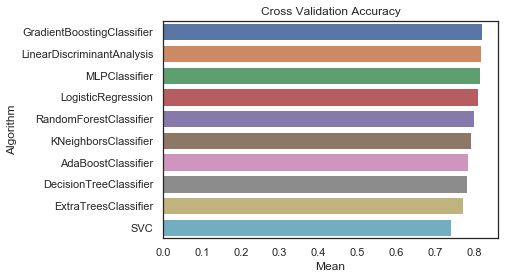

In [724]:
sns.barplot(y='Algorithm', x='Mean', data=cv_res.sort_values(by='Mean', ascending=False))
plt.title('Cross Validation Accuracy')

In [725]:
cv_res.sort_values(by='Mean', ascending=False)

,Algorithm,Mean,Error
5,GradientBoostingClassifier,0.820697,0.034519
9,LinearDiscriminantAnalysis,0.817237,0.029479
6,MLPClassifier,0.815028,0.041048
8,LogisticRegression,0.811555,0.038193
3,RandomForestClassifier,0.801443,0.044166
7,KNeighborsClassifier,0.792288,0.054479
2,AdaBoostClassifier,0.784423,0.042819
1,DecisionTreeClassifier,0.781014,0.044050
4,ExtraTreesClassifier,0.773021,0.036736
0,SVC,0.740105,0.040523


### 6.1.2 Hyperparameter tunning for best models
Grid search optimization for Top5 Algorithms.

In [728]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   18.4s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   36.5s finished


0.8274897854954035

In [729]:
# Gradient boosting tunning

lr = LogisticRegression()
lr_param_grid = {'C' : [0.001,0.01,0.1,1,10,100,1000]}

gsLR = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLR.fit(X_train,y_train)

lr_best = gsLR.best_estimator_

# Best score
gsLR.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   20.4s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   37.6s finished


0.8308988764044944

In [727]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   51.0s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.1min finished


0.8388661899897855

In [730]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,10,100],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 168 candidates, totalling 1680 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 416 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 916 tasks      | elapsed:   47.8s
[Parallel(n_jobs=4)]: Done 1616 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 1680 out of 1680 | elapsed:  1.5min finished


0.8026046986721145

In [726]:
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   45.2s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   56.5s finished


0.8298135852911134

In [731]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   25.3s finished


0.8297369765066394

In [732]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

In [738]:
pred = votingC.predict(X_train)
print(f'Accuracy Score {accuracy_score(pred,y_train)}')
print(f'Precision Score {precision_score(pred,y_train)}')
print(f'Recall Score {recall_score(pred,y_train)}')

Accuracy Score 0.9228149829738933
Precision Score 0.8441176470588235
Recall Score 0.9503311258278145


In [739]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)